<center>
<img src="../../img/ods_stickers.jpg">
## Открытый курс по машинному обучению. Сессия № 2
</center>
Автор материала: программист-исследователь Mail.ru Group, старший преподаватель Факультета Компьютерных Наук ВШЭ Юрий Кашницкий. Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 8. Разреженные данные, онлайн-обучение</center>
## <center>Часть 2. Классификация отзывов к фильмам с SVM и логистической регрессией</center>

In [1]:
import os
os.environ['JOBLIB_TEMP_FOLDER']="/tmp"

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC

**Загрузим данные [отсюда](https://yadi.sk/d/Tg1Tflur333iLr). В обучающей и тестовой выборках по 12500 тысяч хороших и плохих отзывов к фильмам.**

In [3]:
# поменяйте путь к файлу
reviews_train = load_files("../../data_external/aclImdb/train/")
print(reviews_train.target_names)
text_train, y_train = reviews_train.data, reviews_train.target

['neg', 'pos', 'unsup']


In [4]:
# Remove unsup targets:
text_train = np.array(text_train)[y_train < 2]
y_train = y_train[y_train < 2]

In [5]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [6]:
# поменяйте путь к файлу
reviews_test = load_files("../../data_external/aclImdb/test/")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


**Пример отзыва и соответствующей метки.**

In [7]:
text_train[1]

b'If you want Scream or anything like the big-studio horror product that we get forced on us these days don\'t bother. This well-written film kept me up thinking about all it had to say. Importance of myth in our lives to make it make sense, how children interpret the world (and the violence in it), our ransacking of the environment and ignorance of its history and legends.. all here, but not flatly on the surface. You could technically call it a "monster movie" even though the Wendigo does not take physical form until the end, and then it\'s even up to you and your beliefs as to what\'s happening with the legendary spirit/beast. Some standard thriller elements for those looking just for the basics and the film never bores, though in fact the less you see of the creature, the better. Fessenden successfully continues George Romero\'s tradition of using the genre as parable and as a discussion forum while still keeping us creeped out.'

In [8]:
y_train[1] # хороший отзыв

1

In [9]:
text_train[2]

b"Outlandish premise that rates low on plausibility and unfortunately also struggles feebly to raise laughs or interest. Only Hawn's well-known charm allows it to skate by on very thin ice. Goldie's gotta be a contender for an actress who's done so much in her career with very little quality material at her disposal...<br /><br />"

In [10]:
y_train[2] # плохой отзыв

0

**Идея "мешка слов"**

<img src="../../img/bag_of_words.svg" width=80%>

## Простой подсчет слов

**Составим словарь всех слов с помощью CountVectorizer.**

In [11]:
cv = CountVectorizer()
cv.fit(text_train)

len(cv.vocabulary_)

74849

**Посмотрим на примеры полученных "слов" (лучше их называть токенами). Видим, что многие важные этапы обработки текста мы тут пропустили.**

In [12]:
print(cv.get_feature_names()[:50])
print(cv.get_feature_names()[50000:50050])

['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02', '020410', '029', '03', '04', '041', '05', '050', '06', '06th', '07', '08', '087', '089', '08th', '09', '0f', '0ne', '0r', '0s', '10', '100', '1000', '1000000', '10000000000000', '1000lb', '1000s', '1001', '100b', '100k', '100m']
['pincher', 'pinchers', 'pinches', 'pinching', 'pinchot', 'pinciotti', 'pine', 'pineal', 'pineapple', 'pineapples', 'pines', 'pinet', 'pinetrees', 'pineyro', 'pinfall', 'pinfold', 'ping', 'pingo', 'pinhead', 'pinheads', 'pinho', 'pining', 'pinjar', 'pink', 'pinkerton', 'pinkett', 'pinkie', 'pinkins', 'pinkish', 'pinko', 'pinks', 'pinku', 'pinkus', 'pinky', 'pinnacle', 'pinnacles', 'pinned', 'pinning', 'pinnings', 'pinnochio', 'pinnocioesque', 'pino', 'pinocchio', 'pinochet', 'pinochets', 'pinoy', 'pinpoint', 'pinpoints', 'pins', 'pinsent']


**Закодируем предложения из текстов обучающей выборки индексами входящих слов. Используем разреженный формат.**

In [13]:
X_train = cv.transform(text_train)
X_train

<25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3445861 stored elements in Compressed Sparse Row format>

**Посмотрим, как преобразование подействовало на одно из предложений.**

In [14]:
print(text_train[19726])

b"The One and only was a great film. I had just finished viewing it on EncoreW on DirecTV. I am an independent professional wrestler, and I thought this was a good portray of what life is like as a professional wrestler. Now this film was made 4 years before I was born, but I don't think the rigors of professional wrestling traveling has changed all that much. Sad, funny, and all around GREAT!!! **** 10+"


In [15]:
X_train[19726].nonzero()[1]

array([   39,  2662,  2906,  3167,  3258,  4297,  4465,  6579,  8523,
        9881, 11552, 18584, 19563, 21741, 24536, 24666, 26385, 28068,
       28545, 29369, 29999, 33283, 34585, 34683, 35787, 38683, 38755,
       40170, 44241, 46152, 46680, 46916, 46932, 46957, 50946, 51875,
       55851, 57047, 66322, 66339, 66526, 66562, 66621, 67948, 71337,
       72196, 72703, 73795, 73798, 74158], dtype=int32)

In [16]:
X_train[19726].nonzero()

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0], dtype=int32),
 array([   39,  2662,  2906,  3167,  3258,  4297,  4465,  6579,  8523,
         9881, 11552, 18584, 19563, 21741, 24536, 24666, 26385, 28068,
        28545, 29369, 29999, 33283, 34585, 34683, 35787, 38683, 38755,
        40170, 44241, 46152, 46680, 46916, 46932, 46957, 50946, 51875,
        55851, 57047, 66322, 66339, 66526, 66562, 66621, 67948, 71337,
        72196, 72703, 73795, 73798, 74158], dtype=int32))

**Преобразуем так же тестовую выборку.**

In [17]:
X_test = cv.transform(text_test)

**Обучим логистическую регрессию и линейный SVM.**

In [18]:
%%time
logit = LogisticRegression(n_jobs=-1, random_state=7)
logit.fit(X_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


CPU times: user 10.4 s, sys: 12 ms, total: 10.4 s
Wall time: 10.4 s


In [19]:
%%time
svm = LinearSVC(random_state=7)
svm.fit(X_train, y_train)

CPU times: user 4.78 s, sys: 0 ns, total: 4.78 s
Wall time: 4.78 s


**Посмотрим на доли правильных ответов на обучающей и тестовой выборках.**

In [20]:
round(logit.score(X_train, y_train), 3), round(svm.score(X_train, y_train), 3)

(0.998, 1.0)

In [21]:
round(logit.score(X_test, y_test), 3), round(svm.score(X_test, y_test), 3)

(0.867, 0.846)

In [22]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");


In [32]:
def plot_grid_scores(grid, param_name):
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_train_score'],
        color='green', label='train')
    plt.plot(grid.param_grid[param_name], grid.cv_results_['mean_test_score'],
        color='red', label='test')
    plt.legend();
    

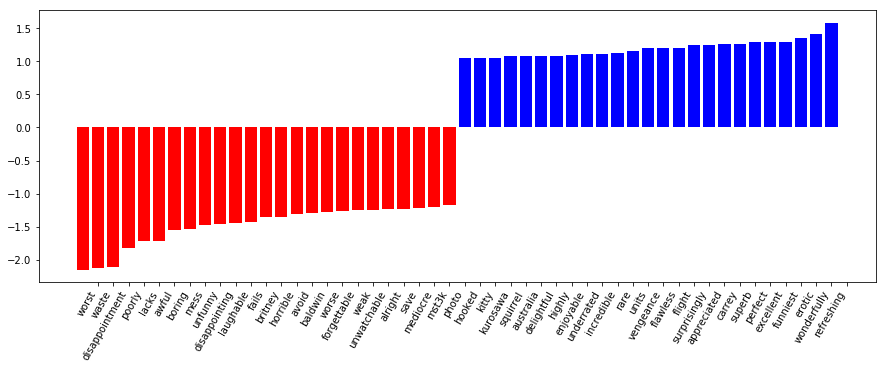

In [24]:
visualize_coefficients(logit, cv.get_feature_names())

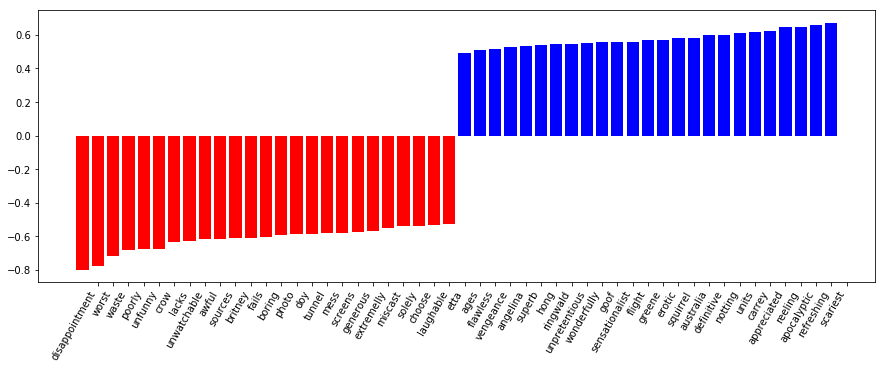

In [25]:
visualize_coefficients(svm, cv.get_feature_names())

**Подберем коэффициент регуляризации для логистической регрессии.**

In [26]:
%%time
from sklearn.pipeline import make_pipeline

text_pipe_logit = make_pipeline(CountVectorizer(), 
                                LogisticRegression(n_jobs=-1, random_state=7))

text_pipe_logit.fit(text_train, y_train)
print(text_pipe_logit.score(text_test, y_test))

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


0.86672
CPU times: user 18.3 s, sys: 16 ms, total: 18.3 s
Wall time: 18.3 s


In [27]:
%%time
from sklearn.model_selection import GridSearchCV

param_grid_logit = {'logisticregression__C': 
                    np.logspace(-5, 0, 6)}
grid_logit = GridSearchCV(text_pipe_logit, param_grid_logit, cv=3, n_jobs=-1)

grid_logit.fit(text_train, y_train)

/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))
/usr/local/lib/python3.5/dist-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect whe

CPU times: user 17.9 s, sys: 360 ms, total: 18.3 s
Wall time: 41 s


**Лучшее значение C и соответствующее качество на кросс-валидации.**

In [28]:
grid_logit.best_params_, grid_logit.best_score_

({'logisticregression__C': 0.1}, 0.88488)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


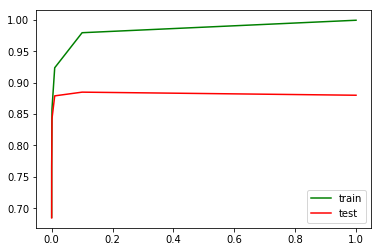

In [33]:
plot_grid_scores(grid_logit, 'logisticregression__C')

**То же самое для LinearSVC.**

In [37]:
%%time
text_pipe_svm = make_pipeline(CountVectorizer(), LinearSVC(random_state=7))

text_pipe_svm.fit(text_train, y_train)
print(text_pipe_svm.score(text_test, y_test))

0.84584
CPU times: user 11.6 s, sys: 8 ms, total: 11.6 s
Wall time: 11.6 s


In [38]:
%%time
param_grid_svm = {'linearsvc__C': np.logspace(-5, 0, 6)}
grid_svm = GridSearchCV(text_pipe_svm, param_grid_svm, cv=3, n_jobs=-1)

grid_svm.fit(text_train, y_train);

CPU times: user 15.8 s, sys: 392 ms, total: 16.2 s
Wall time: 37.1 s


In [39]:
grid_svm.best_params_, grid_svm.best_score_

({'linearsvc__C': 0.01}, 0.88452)

In [40]:
grid_svm.best_params_, grid_svm.best_score_

({'linearsvc__C': 0.01}, 0.88452)

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


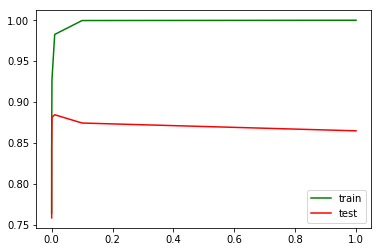

In [41]:
plot_grid_scores(grid_svm, 'linearsvc__C')

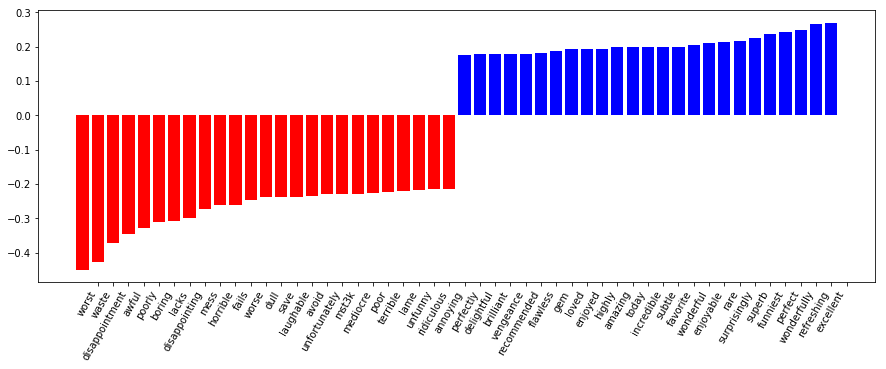

In [42]:
visualize_coefficients(grid_svm.best_estimator_.named_steps['linearsvc'],
                       grid_svm.best_estimator_.named_steps['countvectorizer'].get_feature_names())

На валидационной выборке:

In [43]:
grid_logit.score(text_test, y_test), grid_svm.score(text_test, y_test)

(0.87908, 0.87588)

## TF-IDF

/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


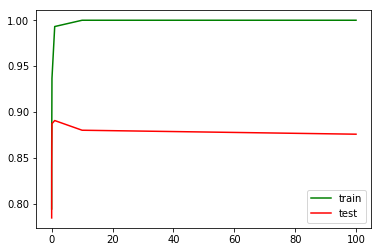

In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_pipe = make_pipeline(TfidfVectorizer(), LinearSVC())

param_grid = {'linearsvc__C': np.logspace(-3, 2, 6)}
grid_tfidf = GridSearchCV(tfidf_pipe, param_grid, cv=3, n_jobs=-1)
grid_tfidf.fit(text_train, y_train)
plot_grid_scores(grid_tfidf, 'linearsvc__C')

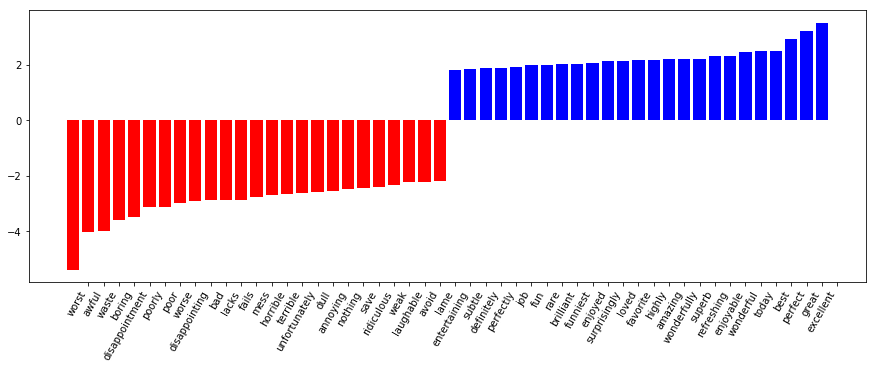

In [45]:
visualize_coefficients(grid_tfidf.best_estimator_.named_steps['linearsvc'],
                       grid_tfidf.best_estimator_.named_steps['tfidfvectorizer'].get_feature_names())

In [46]:
grid_tfidf.best_score_, grid_tfidf.best_params_

(0.89064, {'linearsvc__C': 1.0})

In [49]:
grid_tfidf.score(text_test, y_test)

0.8772

## N-граммы

In [50]:
%%time
text_pipe = make_pipeline(CountVectorizer(), LinearSVC())

param_grid = {'linearsvc__C': [0.01, 0.1, 1],
              "countvectorizer__ngram_range": [(1, 2)]}

grid_bigram = GridSearchCV(text_pipe, param_grid, cv=3, n_jobs=-1)

grid_bigram.fit(text_train, y_train)

CPU times: user 30.6 s, sys: 576 ms, total: 31.1 s
Wall time: 1min 46s


/usr/local/lib/python3.5/dist-packages/sklearn/utils/deprecation.py:122: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)


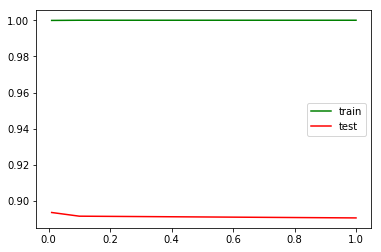

In [51]:
plot_grid_scores(grid_bigram, 'linearsvc__C')

In [52]:
grid_bigram.best_score_

0.8936

In [53]:
grid_bigram.score(text_test, y_test)

0.8954